# **Assignment 3 - RRN - Weather Time Series Forcasting**

# **Name: Akhila Kalpuri**

# **Date: 04-04-2024**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 22:28:45--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.159.0, 54.231.135.120, 16.182.64.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.159.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  54.6MB/s    in 0.2s    

2024-04-07 22:28:46 (54.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

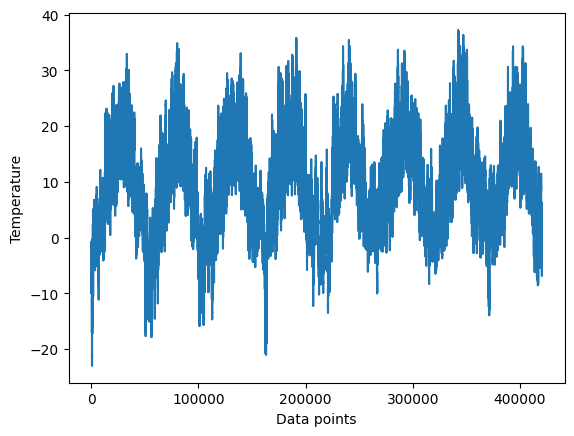

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

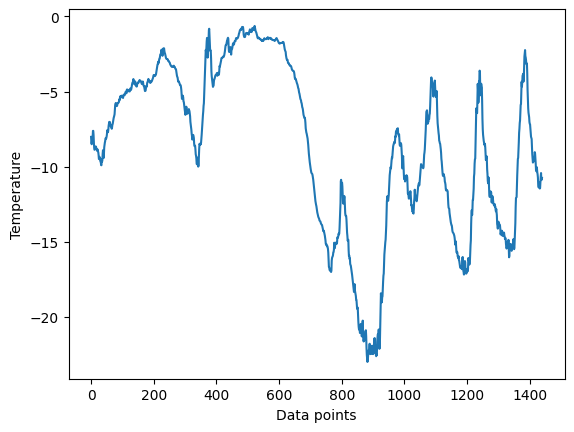

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 52s 62ms/step - loss: 13.0174 - mae: 2.7855 - val_loss: 11.5429 - val_mae: 2.6901
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 9.0771 - mae: 2.3727 - val_loss: 11.0112 - val_mae: 2.6269
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 8.2905 - mae: 2.2716 - val_loss: 17.3812 - val_mae: 3.3651
Epoch 4/10
819/819 [==============================] - 50s 60ms/step - loss: 7.8497 - mae: 2.2082 - val_loss: 10.7525 - val_mae: 2.6070
Epoch 5/10
819/819 [==============================] - 56s 68ms/step - loss: 7.5325 - mae: 2.1664 - val_loss: 12.6078 - val_mae: 2.8362
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 7.3028 - mae: 2.1349 - val_loss: 10.8016 - val_mae: 2.6176
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 7.1156 - mae: 2.1086 - val_loss: 10.6057 - val_mae: 2.5832
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 19s 45ms/step - loss: 11.6681 - mae: 2.6796
Test MAE: 2.68


**Plotting results**

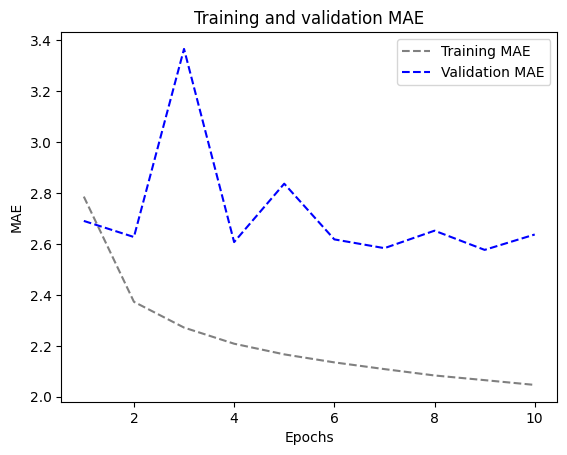

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 92s 111ms/step - loss: 22.1474 - mae: 3.6868 - val_loss: 15.5650 - val_mae: 3.1306
Epoch 2/10
819/819 [==============================] - 90s 109ms/step - loss: 15.9320 - mae: 3.1679 - val_loss: 15.8672 - val_mae: 3.1789
Epoch 3/10
819/819 [==============================] - 89s 109ms/step - loss: 14.7214 - mae: 3.0414 - val_loss: 16.1837 - val_mae: 3.2042
Epoch 4/10
819/819 [==============================] - 91s 111ms/step - loss: 13.7476 - mae: 2.9355 - val_loss: 16.1101 - val_mae: 3.1696
Epoch 5/10
819/819 [==============================] - 94s 115ms/step - loss: 12.9702 - mae: 2.8527 - val_loss: 13.9399 - val_mae: 2.9418
Epoch 6/10
819/819 [==============================] - 91s 110ms/step - loss: 12.3948 - mae: 2.7901 - val_loss: 13.8745 - val_mae: 2.9326
Epoch 7/10
819/819 [==============================] - 93s 113ms/step - loss: 11.9217 - mae: 2.7355 - val_loss: 14.4848 - val_mae: 2.9800
Epoch 8/10
819/819 [=====================

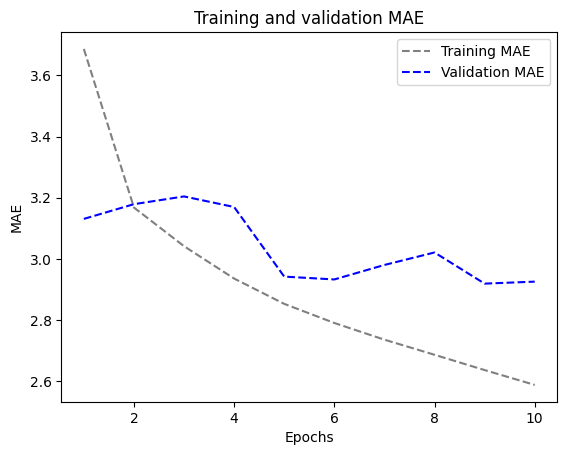

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seem that the convolutional data perform worse compared to common sense or dense model. it could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 80s 97ms/step - loss: 138.5750 - mae: 9.6816 - val_loss: 144.0244 - val_mae: 9.9051
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 136.4122 - mae: 9.5616 - val_loss: 143.8952 - val_mae: 9.8938
Epoch 3/10
819/819 [==============================] - 78s 94ms/step - loss: 136.2548 - mae: 9.5485 - val_loss: 143.7170 - val_mae: 9.8751
Epoch 4/10
819/819 [==============================] - 77s 93ms/step - loss: 136.2142 - mae: 9.5449 - val_loss: 143.6895 - val_mae: 9.8707
Epoch 5/10
819/819 [==============================] - 79s 97ms/step - loss: 136.1743 - mae: 9.5424 - val_loss: 143.6489 - val_mae: 9.8662
Epoch 6/10
819/819 [==============================] - 78s 95ms/step - loss: 136.1386 - mae: 9.5391 - val_loss: 143.6575 - val_mae: 9.8675
Epoch 7/10
819/819 [==============================] - 76s 92ms/step - loss: 136.1154 - mae: 9.5368 - val_loss: 143.6086 - val_mae: 9.8617
Epoch 8/10
819/819 [==============

### **2.Simple RNN - Stacking RNN layers**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 161s 191ms/step - loss: 136.8474 - mae: 9.5675 - val_loss: 143.4280 - val_mae: 9.8400
Epoch 2/10
819/819 [==============================] - 155s 189ms/step - loss: 135.9654 - mae: 9.5139 - val_loss: 143.4168 - val_mae: 9.8388
Epoch 3/10
819/819 [==============================] - 169s 206ms/step - loss: 135.9194 - mae: 9.5071 - val_loss: 143.4075 - val_mae: 9.8352
Epoch 4/10
819/819 [==============================] - 164s 200ms/step - loss: 135.8939 - mae: 9.5035 - val_loss: 143.4572 - val_mae: 9.8428
Epoch 5/10
819/819 [==============================] - 151s 183ms/step - loss: 135.8675 - mae: 9.5003 - val_loss: 143.4481 - val_mae: 9.8415
Epoch 6/10
819/819 [==============================] - 142s 173ms/step - loss: 135.8431 - mae: 9.4968 - val_loss: 143.4338 - val_mae: 9.8403
Epoch 7/10
819/819 [==============================] - 156s 190ms/step - loss: 135.8294 - mae: 9.4942 - val_loss: 143.5148 - val_mae: 9.8523
Epoch 8/10
819/819 [

## **A Simple GRU (Gated Recurrent Unit)**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 141s 170ms/step - loss: 38.2425 - mae: 4.4590 - val_loss: 12.3529 - val_mae: 2.6510
Epoch 2/10
819/819 [==============================] - 119s 145ms/step - loss: 10.4484 - mae: 2.5189 - val_loss: 9.8291 - val_mae: 2.4187
Epoch 3/10
819/819 [==============================] - 138s 169ms/step - loss: 9.5450 - mae: 2.4168 - val_loss: 9.9941 - val_mae: 2.4219
Epoch 4/10
819/819 [==============================] - 123s 149ms/step - loss: 9.2428 - mae: 2.3764 - val_loss: 9.7384 - val_mae: 2.3908
Epoch 5/10
819/819 [==============================] - 120s 146ms/step - loss: 9.0231 - mae: 2.3472 - val_loss: 10.4320 - val_mae: 2.4572
Epoch 6/10
819/819 [==============================] - 118s 144ms/step - loss: 8.8463 - mae: 2.3250 - val_loss: 10.4933 - val_mae: 2.4669
Epoch 7/10
819/819 [==============================] - 138s 168ms/step - loss: 8.6986 - mae: 2.3062 - val_loss: 10.0932 - val_mae: 2.4296
Epoch 8/10
819/819 [======================

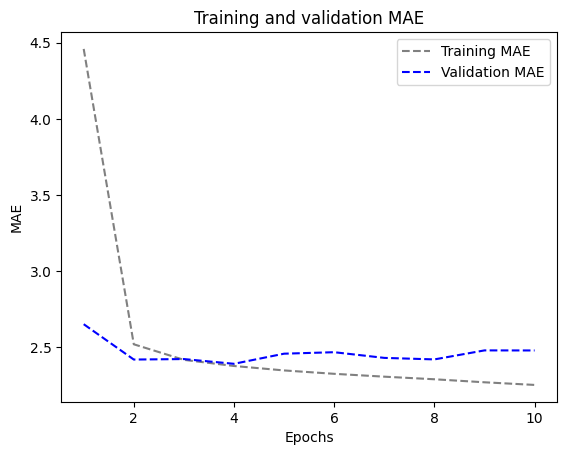

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 152s 180ms/step - loss: 46.0741 - mae: 4.9703 - val_loss: 13.5454 - val_mae: 2.7936
Epoch 2/10
819/819 [==============================] - 123s 149ms/step - loss: 11.4926 - mae: 2.6235 - val_loss: 9.5194 - val_mae: 2.4043
Epoch 3/10
819/819 [==============================] - 135s 165ms/step - loss: 9.9634 - mae: 2.4617 - val_loss: 9.6262 - val_mae: 2.4086
Epoch 4/10
819/819 [==============================] - 139s 170ms/step - loss: 9.3627 - mae: 2.3828 - val_loss: 9.4427 - val_mae: 2.3812
Epoch 5/10
819/819 [==============================] - 137s 167ms/step - loss: 8.8833 - mae: 2.3203 - val_loss: 9.8731 - val_mae: 2.4296
Epoch 6/10
819/819 [==============================] - 124s 151ms/step - loss: 8.5970 - mae: 2.2790 - val_loss: 9.1833 - val_mae: 2.3580
Epoch 7/10
819/819 [==============================] - 122s 149ms/step - loss: 8.3334 - mae: 2.2481 - val_loss: 9.4887 - val_mae: 2.4031
Epoch 8/10
819/819 [=========================

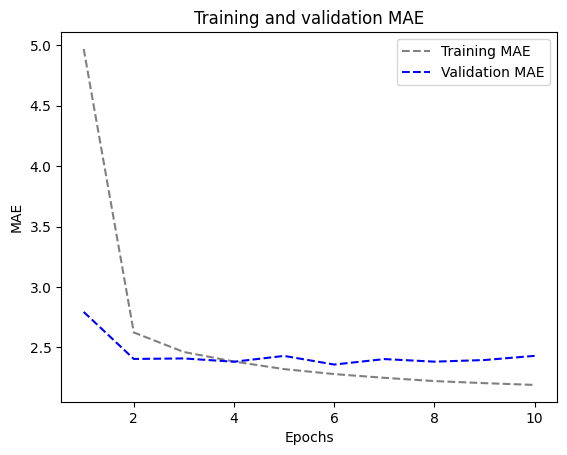

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 206s 249ms/step - loss: 47.9204 - mae: 5.1641 - val_loss: 13.7502 - val_mae: 2.7928
Epoch 2/10
819/819 [==============================] - 189s 231ms/step - loss: 19.9729 - mae: 3.4403 - val_loss: 9.9502 - val_mae: 2.4493
Epoch 3/10
819/819 [==============================] - 202s 246ms/step - loss: 18.2320 - mae: 3.2835 - val_loss: 9.6237 - val_mae: 2.4193
Epoch 4/10
819/819 [==============================] - 189s 230ms/step - loss: 17.3217 - mae: 3.2001 - val_loss: 9.1382 - val_mae: 2.3494
Epoch 5/10
819/819 [==============================] - 190s 231ms/step - loss: 16.6950 - mae: 3.1444 - val_loss: 9.2154 - val_mae: 2.3608
Epoch 6/10
819/819 [==============================] - 189s 231ms/step - loss: 16.2344 - mae: 3.0989 - val_loss: 9.4913 - val_mae: 2.3946
Epoch 7/10
819/819 [==============================] - 190s 231ms/step - loss: 15.6911 - mae: 3.0526 - val_loss: 9.3851 - val_mae: 2.3796
Epoch 8/10
819/819 [====================

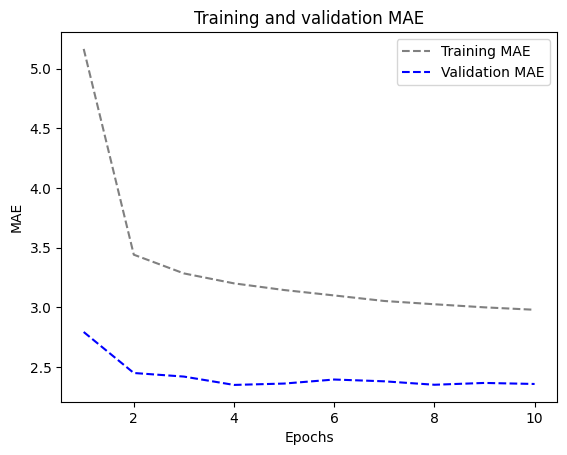

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

### **3.LSTM - Stacked setup with 16 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

AttributeError: 'ellipsis' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

NameError: name 'history' is not defined

### **4.LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built 13 models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** LSTM Stacked setup with 16 units

**Model 10:** LSTM Stacked setup with 32 units

**Model 11:** LSTM Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked up with 8unit

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

<u>**Conclusion:-**</u> We created 14 models total. The first one is not a machine learning model , it’s just the common sense base line method which was giving 2.62 MAE. Later we created the basic machine learning model(danse layer) which gave 2.67 MAE which is slightly higher than the common sense method MAE. The dense layer is not performing well because the connected approach first flattened the timeseries, which removed the notion of time from the input data. We also tried convolution model but it was giving us very poor results because the convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed the order of information.
Hence there is a specific architecture for time series data which is RNN (Recurrent Neural Networks). The key characteristic of an RNN is its ability to use information from previous steps in its current decision-making process. This enables the network to capture dependencies and patterns within sequential data. The internal state of an RNN serves as a memory of the previous inputs it has seen, making it capable of modeling sequences of arbitrary lengths. The simple RNN is generally too simplistic to be of real use. In particular, SimpleRNN has a major issue: As we can see from the graph as well, the simple RNN is the worst performer among all. Theoretically, the SimpleRNN at any time t can retain information for all previous time periods, however, practically it makes learning in the network difficult. This is due to the** vanishing gradient problem**, whereby for deep networks, the network becomes untrainable. The LSTM and GRU RNNs were developed to address this problem and are included as part of Keras. We tried the simple GRU and it showed the best result among all the models due to its ability to capture long-range dependencies in sequential data while being computationally less expensive compared to LSTMs.

LSTMs are one of the most famous architecture to handle time series data and we ran 6 different models for LSTM by changing the units in Stacking recurrent layers to 8,16 and 32. 8 gave the best result among all the 3 units. We also tried Recurrent dropout to avoid overfitting and Bidirectional data which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating the forgetting issue. All of these models have MAE values near to each other and are also lower than the common sense model. We can confirm the same from the MAE evaluation graph.

At the end we also build a model using a combination of 1D convolution model and RNN but it gave a poor 4.01 MAE probably because of the Convolution limitation which is destroying order of information.

<u>**Recommendation:-**</u> As I have observed, simple RNNs suffer from the vanishing gradient problem, making them less effective in capturing long-term dependencies. It's advisable to use more advanced RNN architectures, such as LSTM and GRU, which are designed to mitigate these issues. Also, LSTM is a popular choice for handling time series data due to its ability to capture long-term dependencies, **but experiments have shown that GRU can be a more efficient option. I recommend to try to optimize GRU by tuning the hyperparameters such as the number of units in the stacked recurrent layers, the recurrent dropout rate, and the use of bidirectional data**

Based on the results I obtained, the combination of 1D convolution and RNN did not yield the best performance. Given the limitations of the convolutional approach in destroying the order of information in your time series data, **it's advisable to focus on architectures that are specifically designed for handling sequential data, such as pure RNNs.**
